In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import PAIRWISE_KERNEL_FUNCTIONS
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel, pairwise_kernels

def standardize(x):
	return (x - x.mean(dim=0)) / x.std(dim=0)

def get_rbf_kernel(x, gamma=1):
    pairwise_dists = torch.cdist(x, x, p=2) ** 2 # TODO: produce numerical error for diag elements
    # pairwise_dists = torch.from_numpy(euclidean_distances(x, x)) ** 2
    return (-gamma * pairwise_dists).exp()

# def get_rbf_kernel(x, bandwidth):
#     pairwise_dists = torch.cdist(x, x, p=2) ** 2
#     return torch.div(-pairwise_dists, (2 * bandwidth ** 2)).exp()

def compute_kernel(x, y=None, kernel="linear", **params):
    if kernel not in PAIRWISE_KERNEL_FUNCTIONS:
        raise ValueError(f"invalid kernel: {kernel}")

    return pairwise_kernels(x, y, metric=kernel, filter_params=True, **params)
                   
# def get_hsic(x, y, kernel, center=False, normalize=False, **params):
#     K_x = compute_kernel(x, kernel=kernel, **params)
#     K_y = compute_kernel(y, kernel=kernel, **params)

def get_hsic(x, y, center=False, gamma=1):
    x, y = standardize(x), standardize(y)
    K_x = get_rbf_kernel(x, gamma=gamma)
    K_y = get_rbf_kernel(y, gamma=gamma)

    if center:
        # K_x = KernelCenterer().fit_transform(K_x)
        # K_y = KernelCenterer().fit_transform(K_y)
        n_samples = len(x)
        H = torch.eye(n_samples) - (1 / n_samples) * torch.ones(n_samples, n_samples)
        K_x = H @ K_x @ H
        K_y = H @ K_y @ H
    
    hsic = torch.sum(K_x * K_y)
    return hsic, K_x, K_y

def get_cka(x, y, gamma=1):
    hsic, K_x, K_y = get_hsic(x, y, center=True, gamma=gamma)
    K_x_norm = torch.linalg.norm(K_x)
    K_y_norm = torch.linalg.norm(K_y)
    
    cka = hsic / (K_x_norm * K_y_norm)
    return cka

In [13]:
import numpy as np 
from collections import defaultdict
from pysim.pysim.kernel.hsic import HSIC ## reference

batch_size = 512 # 128
x_size = 64

sd = 1
repeats = 10
gammas = 10**np.linspace(-7,0,8)
# gammas = [1/18.]
deps = np.linspace(0, 1, 21)
means, sds = defaultdict(list), defaultdict(list)

for gamma in gammas:
    print(gamma)
    for dep in deps:
        values = []
        for _ in range(repeats):
        
            X = sd * torch.randn(batch_size, x_size)
            eps = sd * torch.randn(batch_size, x_size)
            Y = dep * X + (1 - dep) * eps

            # score, _, _ = get_hsic(X, Y, center=True, gamma=gamma)
            score = get_cka(X, Y, gamma=gamma)

            # hsic = HSIC(center=True, gamma_X=gamma, gamma_Y=gamma, kernel="rbf")
            # hsic.fit(X, Y)
            # score2 = hsic.score(1, normalize=True)

            # if abs(score.item() - score2) > 1e-3:
            #     print(score.item(), score2)

            
            values.append(score)
        
        means[gamma].append(np.mean(values))
        sds[gamma].append(np.std(values))

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0


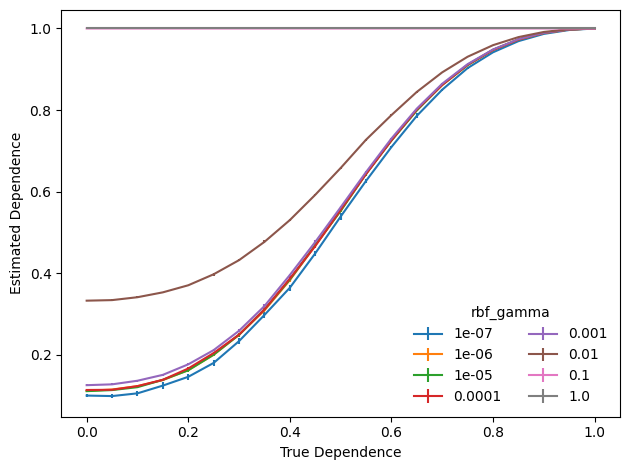

In [14]:
import matplotlib.pyplot as plt 

for k in gammas:
    plt.errorbar(deps, means[k], yerr=sds[k], label=k)

plt.xlabel("True Dependence")
plt.ylabel("Estimated Dependence")
plt.tight_layout()
plt.legend(title="rbf_gamma", frameon=False, ncols=2)

<ErrorbarContainer object of 3 artists>

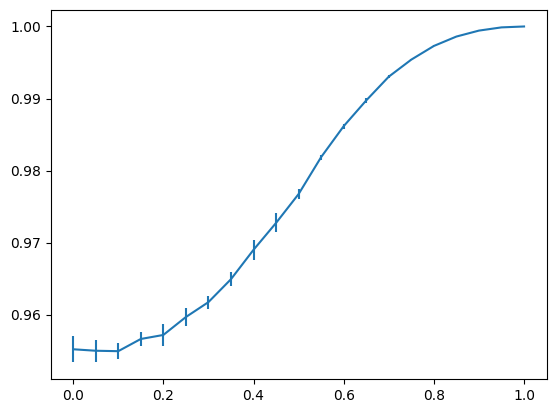

In [50]:
plt.errorbar(deps, means[0.01], yerr=sds[0.01], label=k)

<ErrorbarContainer object of 3 artists>

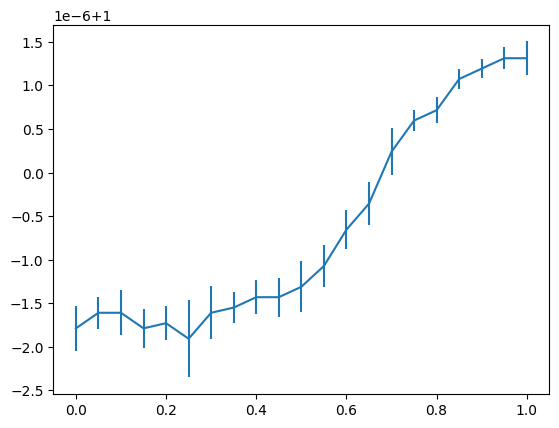

In [51]:
plt.errorbar(deps, means[0.1], yerr=sds[0.1], label=k)